# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib
import gzip
import json
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 175 kB 7.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=80ee44cb9c6b27a455717180b47fbd9a1b8f76e6e7890051561e49b844e3793d
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


## Set Up paths

In [2]:
# Parent paths
parent_path = '/content/drive/My Drive/'


#Specific paths
path_hyperparameters_nb = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/nb.csv"
path_hyperparameters_knn = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/knn.csv"
path_hyperparameters_rf = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/rf.csv"
path_hyperparameters_svm = parent_path+"Web_Mining_Project/classifier_parameters/best_parameters/svm.csv"

path_best_parameters_nb = parent_path+"Web_Mining_Project/classifier_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"Web_Mining_Project/classifier_parameters/knn.pkl"
path_best_parameters_rf = parent_path+"Web_Mining_Project/classifier_parameters/rf.pkl"
path_best_parameters_svm = parent_path+"Web_Mining_Project/classifier_parameters/svm.pkl"
#dataset paths 
path_complete_dataset = parent_path + "Web_Mining_Project/data/complete_dataset.csv"
path_shortend_dataset = parent_path + "Web_Mining_Project/data/shortend10000_dataset.csv"

## Set Up Functions

In [3]:
# function for evaluation(confusion matrix)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# function for sentiment label creating 
def create_labels_from_rating(score):
  score = int(score)
  if score <= 2:
    return 0 #negative
  elif score == 3:
    return 1 #neutral
  else:
    return 2 #positive
  

# Data Download and Exploration

In [4]:
# create dataframe 
df = pd.read_csv(path_shortend_dataset)
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(10000, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


overall           False
verified          False
reviewTime        False
reviewerID        False
asin              False
reviewerName      False
reviewText        False
summary            True
unixReviewTime    False
vote               True
style              True
image              True
dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  float64
 1   verified        10000 non-null  bool   
 2   reviewTime      10000 non-null  object 
 3   reviewerID      10000 non-null  object 
 4   asin            10000 non-null  object 
 5   reviewerName    10000 non-null  object 
 6   reviewText      10000 non-null  object 
 7   summary         9999 non-null   object 
 8   unixReviewTime  10000 non-null  int64  
 9   vote            2716 non-null   float64
 10  style           3784 non-null   object 
 11  i

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


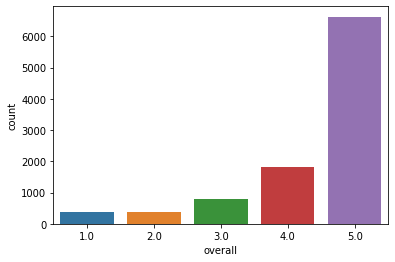

In [5]:
# General Information and Null values
print(df.isnull().any())
print()
df.info()
print()
print(df.dtypes)
print()
print(df.overall.describe())
print()
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.overall)
plt.show()
print()

# Data Preprocessing and further Exploration

## Label creation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


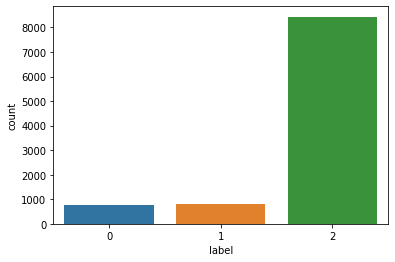

In [6]:
df['label'] = df['overall'].apply(create_labels_from_rating)
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.label)
plt.show()

## Feature Generation and Selection

In [7]:
# Frequency encoding using value_counts function
reviewerID_freq = df['reviewerID'].value_counts()
# Mapping the encoded values with original data
df['reviewer_amount_of_reviews'] = df['reviewerID'].apply(lambda x : reviewerID_freq[x])
# detecting mean of ratings score per user
df['reviewer_mean_score'] = df.groupby(['reviewerID'])['overall'].transform(lambda x: x.mean())
df.drop(columns=['reviewTime', 'reviewerName', 'vote', 'style', 'image'], inplace=True)
print(df.shape)

(10000, 10)


In [8]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]
df.dropna(inplace=True)
print(df.shape)
print(df.head())

(9999, 10)
   overall  verified      reviewerID        asin  \
0      5.0      True  A1HP7NVNPFMA4N  0700026657   
1      4.0     False  A1JGAP0185YJI6  0700026657   
2      3.0      True  A1YJWEXHQBWK2B  0700026657   
3      2.0      True  A2204E1TH211HT  0700026657   
4      5.0      True  A2RF5B5H74JLPE  0700026657   

                                          reviewText  \
0  This game is a bit hard to get the hang of, bu...   
1  I played it a while but it was alright. The st...   
2                                           ok game.   
3  found the game a bit too complicated, not what...   
4  great game, I love it and have played it since...   

                                       summary  unixReviewTime  label  \
0                  but when you do it's great.      1445040000      2   
1  But in spite of that it was fun, I liked it      1437955200      2   
2                                  Three Stars      1424649600      1   
3                                    Two Stars 

## Emoji Detection and Replacement

In [9]:
text = df['reviewText']
label = df['label']
summaries = df['summary']

list_texts = list(text)
list_summaries = list(summaries)

pure_texts = []
for text in list_texts:
  pure_text = emoji.demojize(text, language='en')
  pure_texts.append(pure_text)

pure_summaries = []
for summary in list_summaries:
  pure_summary = emoji.demojize(summary, language='en')
  pure_summaries.append(pure_summary) 

print(pure_texts[:5])
print(pure_summaries[:5])

["This game is a bit hard to get the hang of, but when you do it's great.", 'I played it a while but it was alright. The steam was a bit of trouble. The more they move these game to steam the more of a hard time I have activating and playing a game. But in spite of that it was fun, I liked it. Now I am looking forward to anno 2205 I really want to play my way to the moon.', 'ok game.', 'found the game a bit too complicated, not what I expected after having played 1602, 1503, and 1701', 'great game, I love it and have played it since its arrived']
["but when you do it's great.", 'But in spite of that it was fun, I liked it', 'Three Stars', 'Two Stars', 'love this game']


## Data Transformation

In [10]:
def transform_text(text):

    # lowercasing
    text = text.lower()
    
    # remove everything that is not a word 
    text =  re.sub("[^a-z]+", " ",text)

    # remove Links 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    
    return text

finished_text = []
for i in range(len(pure_texts)):
    finished_text.append(transform_text(pure_texts[i]))


finished_summaries = []
for i in range(len(pure_summaries)):
    finished_summaries.append(transform_text(pure_summaries[i]))

print(finished_text[:1])
print(finished_summaries[:1])

text_without_sw = pd.DataFrame(finished_text,columns=['reviewText'])
summaries_without_sw = pd.DataFrame(finished_summaries, columns=['summary'])
text_and_summary = pd.concat([summaries_without_sw, text_without_sw], axis=1)
print(text_and_summary.shape)
print(df.shape)
df.reset_index(drop=True)
df.drop(columns =['reviewText', 'summary'], inplace = True)
df['reviewText'] = text_and_summary['reviewText']
df['summary'] = text_and_summary['summary']
print(df.head)

['this game is a bit hard to get the hang of but when you do it s great ']
['but when you do it s great ']
(9999, 2)
(9999, 10)
<bound method NDFrame.head of       overall  verified      reviewerID        asin  unixReviewTime  label  \
0         5.0      True  A1HP7NVNPFMA4N  0700026657      1445040000      2   
1         4.0     False  A1JGAP0185YJI6  0700026657      1437955200      2   
2         3.0      True  A1YJWEXHQBWK2B  0700026657      1424649600      1   
3         2.0      True  A2204E1TH211HT  0700026657      1424390400      0   
4         5.0      True  A2RF5B5H74JLPE  0700026657      1419465600      2   
...       ...       ...             ...         ...             ...    ...   
9995      5.0     False  A3NY3HRSDU16NC  B00002SVFM      1389657600      2   
9996      5.0      True  A34210QTNJZBJX  B00002SVFM      1388707200      2   
9997      5.0     False  A3J8ABVGK7ZL6H  B00002SVFM      1379376000      2   
9998      5.0      True  A1P9TAGWA2VAE4  B00002SVFM      13756

## Tokenization 

In [11]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]
# tokenize and remove stopwords 
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.dropna(inplace=True)
print(df.head())
print(df.shape)

   overall  verified      reviewerID        asin  unixReviewTime  label  \
0      5.0      True  A1HP7NVNPFMA4N  0700026657      1445040000      2   
1      4.0     False  A1JGAP0185YJI6  0700026657      1437955200      2   
2      3.0      True  A1YJWEXHQBWK2B  0700026657      1424649600      1   
3      2.0      True  A2204E1TH211HT  0700026657      1424390400      0   
4      5.0      True  A2RF5B5H74JLPE  0700026657      1419465600      2   

   reviewer_amount_of_reviews  reviewer_mean_score  \
0                           1                  5.0   
1                           1                  4.0   
2                           1                  3.0   
3                           1                  2.0   
4                           2                  5.0   

                                          reviewText          summary  
0                       game bit hard get hang great            great  
1  played alright steam bit trouble move game ste...  spite fun liked  
2       

# Train Test Split and shortening 

In [12]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]

In [13]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
y_test = x_test['label']
y_valid = x_valid['label']


print (f"y_train: {y_train.shape}/ x_train: {x_train.shape}")
print (f"y_test: {y_test.shape}/ x_test: {x_test.shape}")
print (f"y_valid: {y_valid.shape}/ x_valid: {x_valid.shape}")
print(x_train.head())

y_train: (7998,)/ x_train: (7998, 10)
y_test: (1000,)/ x_test: (1000, 10)
y_valid: (1000,)/ x_valid: (1000, 10)
      overall  verified      reviewerID        asin  unixReviewTime  label  \
2285      2.0     False   ACGBAI00YLEBW  B00000IODY      1346889600      0   
7395      5.0      True  A25CSU2SI8YT2Z  B00002ST7F      1487203200      2   
1014      5.0      True  A2FCAVRCM0JWQ2  B00000DMAX      1423699200      2   
5849      5.0      True  A1R36B8EO01ITE  B000021Y4W      1363219200      2   
6502      5.0     False   AL8QVSCIGU174  B00002CF9M      1002240000      2   

      reviewer_amount_of_reviews  reviewer_mean_score  \
2285                           3             3.000000   
7395                           1             5.000000   
1014                           4             4.500000   
5849                           2             5.000000   
6502                           3             3.666667   

                                             reviewText  \
2285  early milit

# Model Training

## Set Up Pipeline

In [14]:

# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score, average='weighted')

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# dataset preparation
x_train.drop(columns = ['label'], inplace= True)
x_train = x_train['reviewText']
x_valid = x_valid['reviewText']
print(x_train.shape)
print(y_train.shape)
x_train.head(5)




(7998,)
(7998,)


2285    early military simulation type game pretty muc...
7395      classic arguably best genesis fun players couch
1014                            game remember works great
5849    played game alote child bought shipping came f...
6502    simply superb game stable listen said run mach...
Name: reviewText, dtype: object

## Naïve Bayes

In [15]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of possible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer),('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 548.1489636898041 seconds ---
Multinomial NBClassifier: 78.23697483547136% F1-score for class 'label' with parameters {'estimator__alpha': 10, 'vectorizer__max_df': 0.75, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/Web_Mining_Project/classifier_parameters/nb.pkl']

              precision    recall  f1-score   support

           0       0.29      0.43      0.35        75
           1       0.17      0.33      0.22        81
           2       0.90      0.78      0.84       844

    accuracy                           0.72      1000
   macro avg       0.45      0.51      0.47      1000
weighted avg       0.80      0.72      0.75      1000



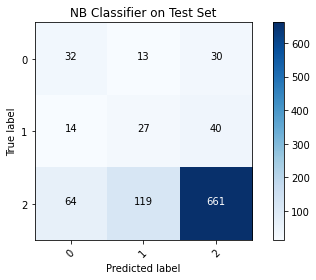

In [16]:
x_test = x_test['reviewText']
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))